### Compare Calibrations
*Perform oxygen calibration on same float that has WOA calibrated data in FloatViz*

See [FloatList](http://www.mbari.org/chemsensor/FloatList.html) and [6881StnPQC.txt](http://www.mbari.org/lobo/Data/FloatVizData/QC/6881StnPQC.txt). See the Notebook [explore_surface_oxygen_and_WOA.ipynb](explore_surface_oxygen_and_WOA.ipynb) for explanations of what is executed below.

The gain calculated for this float is **1.12**. Let's see if we get the same number.

In [1]:
import sys
sys.path.insert(0, '../')
from biofloat import ArgoData
ad = ArgoData(cache_file='6881StnP_5903891.hdf')

In [2]:
%%time
wmo_list = ['5903891']
df = ad.get_float_dataframe(wmo_list)

ERROR:root:ServerError opening http://tds0.ifremer.fr/thredds/dodsC/CORIOLIS-ARGO-GDAC-OBS/aoml/5903891/profiles/R5903891_104.nc
ERROR:root:ServerError opening http://tds0.ifremer.fr/thredds/dodsC/CORIOLIS-ARGO-GDAC-OBS/aoml/5903891/profiles/R5903891_103.nc
ERROR:root:ServerError opening http://tds0.ifremer.fr/thredds/dodsC/CORIOLIS-ARGO-GDAC-OBS/aoml/5903891/profiles/R5903891_102.nc
ERROR:root:ServerError opening http://tds0.ifremer.fr/thredds/dodsC/CORIOLIS-ARGO-GDAC-OBS/aoml/5903891/profiles/R5903891_101.nc
ERROR:root:ServerError opening http://tds0.ifremer.fr/thredds/dodsC/CORIOLIS-ARGO-GDAC-OBS/aoml/5903891/profiles/R5903891_100.nc
ERROR:root:ServerError opening http://tds0.ifremer.fr/thredds/dodsC/CORIOLIS-ARGO-GDAC-OBS/aoml/5903891/profiles/R5903891_099.nc


CPU times: user 32.1 s, sys: 1.78 s, total: 33.9 s
Wall time: 15min 25s


Populating the interactive namespace from numpy and matplotlib


/home/mccann/VirtualEnvs/biofloat/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


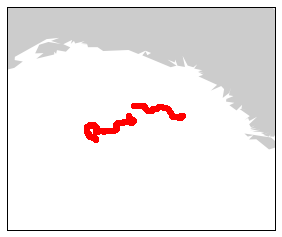

In [3]:
%pylab inline
import pylab as plt
from mpl_toolkits.basemap import Basemap

def map(lons, lats):
    m = Basemap(llcrnrlon=-155, llcrnrlat=40, urcrnrlon=-125, urcrnrlat=65, projection='cyl')
    m.fillcontinents(color='0.8')
    m.scatter(lons, lats, latlon=True, color='red')

map(df.index.get_level_values('lon'), df.index.get_level_values('lat'))

In [4]:
sdf = df.query('pressure < 10').groupby(level=['wmo', 'time', 'lon', 'lat']).mean()
sdf['lon'] = sdf.index.get_level_values('lon')
sdf['lat'] = sdf.index.get_level_values('lat')
sdf['month'] = sdf.index.get_level_values('time').month
sdf['year'] = sdf.index.get_level_values('time').year
sdf['wmo'] = sdf.index.get_level_values('wmo')

In [5]:
msdf = sdf.groupby(['wmo', 'year', 'month']).mean()
from biofloat.utils import o2sat, convert_to_mll
msdf['o2sat'] = 100 * (msdf.DOXY_ADJUSTED / o2sat(msdf.PSAL_ADJUSTED, msdf.TEMP_ADJUSTED))

In [6]:
def round_to(n, increment, mark):
    correction = mark if n >= 0 else -mark
    return int( n / increment) + correction

imsdf = msdf.copy()
imsdf['ilon'] = msdf.apply(lambda x: round_to(x.lon, 1, 0.5), axis=1)
imsdf['ilat'] = msdf.apply(lambda x: round_to(x.lat, 1, 0.5), axis=1)

In [7]:
woa_tmpl = 'http://data.nodc.noaa.gov/thredds/dodsC/woa/WOA13/DATA/o2sat/netcdf/all/1.00/woa13_all_O{:02d}_01.nc'
woa = {}
for m in range(1,13):
    woa[m] = woa_tmpl.format(m)

In [8]:
import xray
def woa_o2sat(month, depth, lon, lat):
    ds = xray.open_dataset(woa[month], decode_times=False)
    return ds.loc[dict(lon=lon, lat=lat, depth=depth)]['O_an'].values[0]

In [9]:
%%time
woadf = imsdf.copy()
woadf['month'] = woadf.index.get_level_values('month')
woadf['woa_o2sat'] = woadf.apply(lambda x: woa_o2sat(x.month, 5.0, x.ilon, x.ilat), axis=1)

CPU times: user 837 ms, sys: 125 ms, total: 962 ms
Wall time: 35.2 s


In [10]:
gdf = woadf[['o2sat', 'woa_o2sat']].copy()
gdf['wmo'] = gdf.index.get_level_values('wmo')
years = gdf.index.get_level_values('year')
months = gdf.index.get_level_values('month')

/home/mccann/VirtualEnvs/biofloat/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


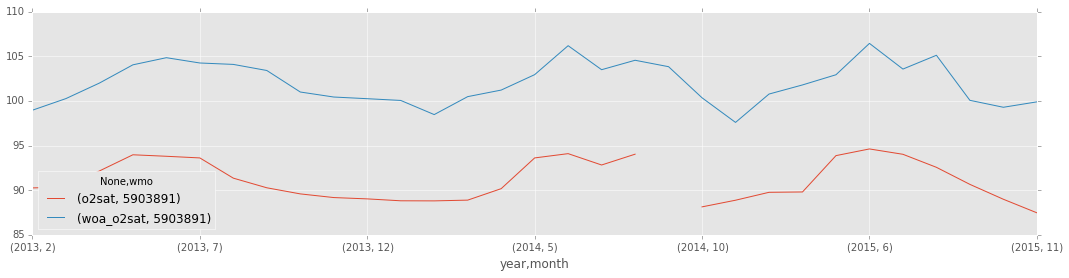

In [11]:
import matplotlib as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18.0, 4.0)
gdf[['o2sat', 'woa_o2sat']].unstack(level=0).plot()

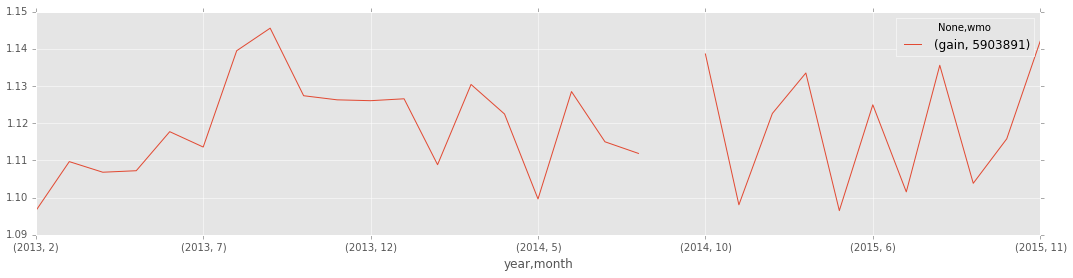

In [12]:
gdf['gain'] = gdf.woa_o2sat / gdf.o2sat
gdf[['gain']].unstack(level=0).plot()

In [13]:
gdf.groupby('wmo').gain.mean()

wmo
5903891    1.119085
Name: gain, dtype: float64

How about that! This calcualtion also comes up with **1.12**.